# In the Name of God
## Deep Learning HW4 - Problem 1
## Sayed Pouria fatemi 400206324


<div dir="rtl"> <font size="4" face="vazirmatn">    
برای این سوال از سایت 

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

کمک گرفته شده است.
</font> </div> 

##Preprocessing

In [19]:
import time, random, math, string

import numpy as np
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Embedding, Masking, GRU, Dropout, concatenate
from keras import metrics , losses, optimizers
import pandas as pd
from google.colab import drive
import itertools
from keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/ferdousi.txt', header=None, names=['verse'])
df = df[2:-1]
df = df.groupby(df.index // 2).agg(' / '.join).reset_index(drop= True)
verses = list(df.verse)
verses = [[*item] for item in verses]

unique_char = list(set(itertools.chain.from_iterable(verses)))
unique_char.append('SOL')
unique_char.append('EOL')
unique_char.append('UNK')
dict_size = len(unique_char)

index2char = dict(enumerate(unique_char))
char2index = inv_map = {v: k for k, v in index2char.items()}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
encoded_verses = []
for verse in verses:
  encoded_verse = [char2index['SOL']]
  for char in verse:
    encoded_verse.append(char2index[char])
  encoded_verse.append(char2index['EOL'])
  encoded_verses.append(encoded_verse)

encoder_input_data = pad_sequences(encoded_verses[:-1], padding='post', value=char2index['UNK'])
decoder_input_data = pad_sequences(encoded_verses[1:], padding='post', value=char2index['UNK'])
maxlen = encoder_input_data.shape[1]
target_data = pad_sequences(decoder_input_data[:, 1:], maxlen= maxlen, padding='post', value=char2index['UNK'])

##Part (a)

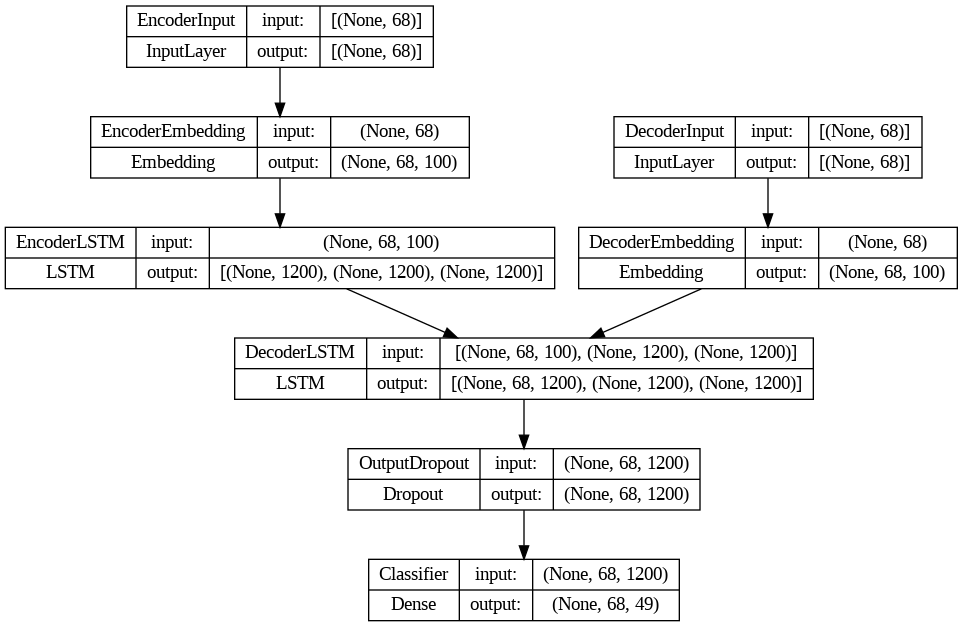

In [4]:
latent_dim = 100
states_num = 1200

encoder_input = Input(shape=(maxlen,), name= 'EncoderInput')
encoder_embedding = Embedding(dict_size, latent_dim, name= 'EncoderEmbedding')(encoder_input)
_, state_h, state_c = LSTM(states_num,return_state=True, name= 'EncoderLSTM')(encoder_embedding)

decoder_input = Input(shape=(maxlen,), name= 'DecoderInput')
decoder_embedding = Embedding(dict_size, latent_dim, name= 'DecoderEmbedding')(decoder_input)
output,_,_ = LSTM(states_num, return_sequences=True, return_state=True, name= 'DecoderLSTM')(decoder_embedding, initial_state=[state_h, state_c])

output = Dropout(0.4, name= 'OutputDropout')(output)
output = Dense(dict_size, activation='softmax', name= 'Classifier')(output)

LSTM_model = Model([encoder_input, decoder_input], output)
plot_model(LSTM_model, show_shapes=True)

In [5]:
LSTM_model.compile(loss= losses.SparseCategoricalCrossentropy(),
              optimizer= optimizers.Adam(learning_rate = 5e-4),
              metrics= 'accuracy')

LSTM_history = LSTM_model.fit([encoder_input_data, decoder_input_data],
                               target_data,
                               batch_size= 50,
                               epochs= 10,
                               validation_split= 0.2)

Epoch 1/10
794/794 [==============================] - 109s 122ms/step - loss: 1.9296 - accuracy: 0.4632 - val_loss: 1.5405 - val_accuracy: 0.5459
Epoch 2/10
794/794 [==============================] - 97s 122ms/step - loss: 1.3915 - accuracy: 0.5891 - val_loss: 1.2698 - val_accuracy: 0.6272
Epoch 3/10
794/794 [==============================] - 97s 122ms/step - loss: 1.1854 - accuracy: 0.6461 - val_loss: 1.1319 - val_accuracy: 0.6658
Epoch 4/10
794/794 [==============================] - 97s 122ms/step - loss: 1.0675 - accuracy: 0.6791 - val_loss: 1.0529 - val_accuracy: 0.6882
Epoch 5/10
794/794 [==============================] - 97s 122ms/step - loss: 0.9951 - accuracy: 0.6994 - val_loss: 1.0074 - val_accuracy: 0.7009
Epoch 6/10
794/794 [==============================] - 98s 123ms/step - loss: 0.9448 - accuracy: 0.7135 - val_loss: 0.9792 - val_accuracy: 0.7088
Epoch 7/10
794/794 [==============================] - 98s 123ms/step - loss: 0.9063 - accuracy: 0.7245 - val_loss: 0.9685 - val_a

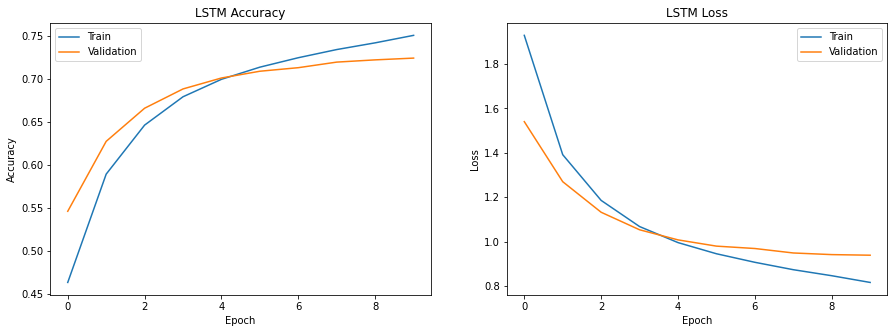

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

plt.sca(axs[0])
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.sca(axs[1])
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [6]:
_, enc_h, enc_c = LSTM_model.get_layer('EncoderLSTM').output
LSTM_encoder_model = Model(LSTM_model.get_layer('EncoderInput').input , [enc_h, enc_c])

dec_initial_h = Input((states_num,))
dec_initial_c = Input((states_num,))
dec_output, dec_h, dec_c = LSTM_model.get_layer('DecoderLSTM')(LSTM_model.get_layer('DecoderEmbedding').output,
                                                               initial_state= [dec_initial_h, dec_initial_c])
dec_output = LSTM_model.get_layer('OutputDropout')(dec_output)
dec_output = LSTM_model.get_layer('Classifier')(dec_output)
LSTM_decoder_model = Model([LSTM_model.get_layer('DecoderInput').input, dec_initial_h, dec_initial_c],
                      [dec_output, dec_h, dec_c])

In [39]:
verse_index = np.random.randint(len(df.verse))
input_verse = np.expand_dims(encoder_input_data[verse_index], 0)
next_char = "SOL"
predicted_verse = ""
state_h, state_c = LSTM_encoder_model.predict(input_verse)

while True:

    input_char = np.array(char2index[next_char]).reshape(1,1)
    probs, state_h, state_c = LSTM_decoder_model.predict([input_char, state_h, state_c])
    next_char = index2char[np.random.choice(range(dict_size), p=probs.flatten())]

    if next_char == "EOL":
      break

    predicted_verse += next_char

print()
print('LSTM:')
print("بیت ورودی:")
print(df.verse[verse_index])
print()
print("بیت خروجی:")
print(predicted_verse)

1/1 [==============================] - 0s 20ms/step

LSTM:
بیت ورودی:
نهادند مهر از بر مشک چین / فرستاده را داد و کرد آفرین

بیت خروجی:
بباید به خواهش نباشم ز جای / به داد و به تیمار و تندی به پای


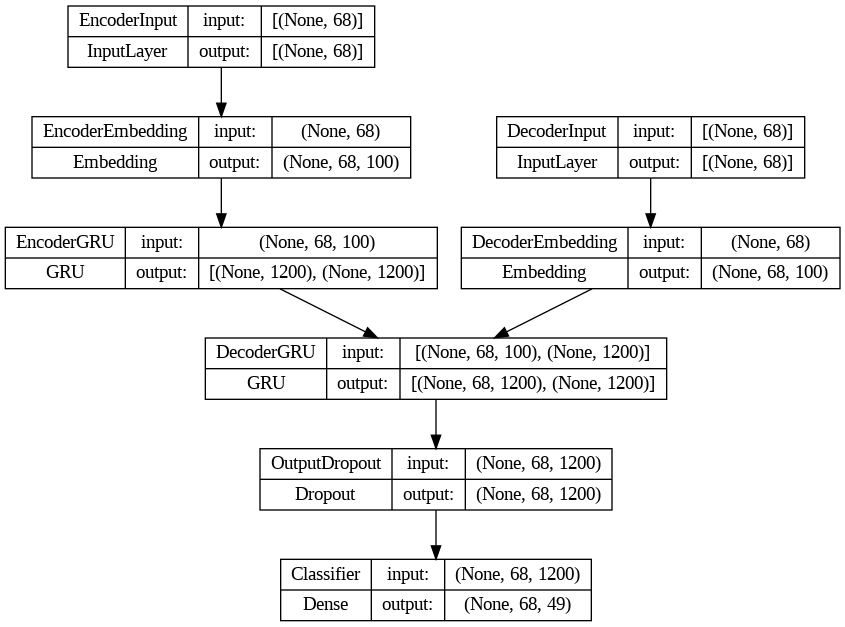

In [26]:
encoder_input = Input(shape=(maxlen,), name= 'EncoderInput')
encoder_embedding = Embedding(dict_size, latent_dim, name= 'EncoderEmbedding')(encoder_input)
_, state_h = GRU(states_num,return_state=True, name= 'EncoderGRU')(encoder_embedding)

decoder_input = Input(shape=(maxlen,), name= 'DecoderInput')
decoder_embedding = Embedding(dict_size, latent_dim, name= 'DecoderEmbedding')(decoder_input)
output,_ = GRU(states_num, return_sequences=True, return_state=True, name= 'DecoderGRU')(decoder_embedding, initial_state= state_h)

output = Dropout(0.4, name= 'OutputDropout')(output)
output = Dense(dict_size, activation='softmax', name= 'Classifier')(output)

GRU_model = Model([encoder_input, decoder_input], output)
plot_model(GRU_model, show_shapes=True)

##Part (b)

In [9]:
GRU_model.compile(loss= losses.SparseCategoricalCrossentropy(),
              optimizer= optimizers.Adam(learning_rate = 5e-4),
              metrics= 'accuracy')

GRU_history = GRU_model.fit([encoder_input_data, decoder_input_data],
                             target_data,
                             batch_size= 50,
                             epochs= 10,
                             validation_split= 0.2)

Epoch 1/10
794/794 [==============================] - 81s 98ms/step - loss: 1.9538 - accuracy: 0.4582 - val_loss: 1.6390 - val_accuracy: 0.5202
Epoch 2/10
794/794 [==============================] - 76s 96ms/step - loss: 1.4797 - accuracy: 0.5633 - val_loss: 1.3384 - val_accuracy: 0.6085
Epoch 3/10
794/794 [==============================] - 77s 96ms/step - loss: 1.2515 - accuracy: 0.6275 - val_loss: 1.1858 - val_accuracy: 0.6502
Epoch 4/10
794/794 [==============================] - 76s 96ms/step - loss: 1.1283 - accuracy: 0.6617 - val_loss: 1.1035 - val_accuracy: 0.6730
Epoch 5/10
794/794 [==============================] - 76s 96ms/step - loss: 1.0534 - accuracy: 0.6821 - val_loss: 1.0575 - val_accuracy: 0.6863
Epoch 6/10
794/794 [==============================] - 77s 97ms/step - loss: 1.0009 - accuracy: 0.6969 - val_loss: 1.0250 - val_accuracy: 0.6967
Epoch 7/10
794/794 [==============================] - 77s 97ms/step - loss: 0.9595 - accuracy: 0.7089 - val_loss: 1.0015 - val_accuracy:

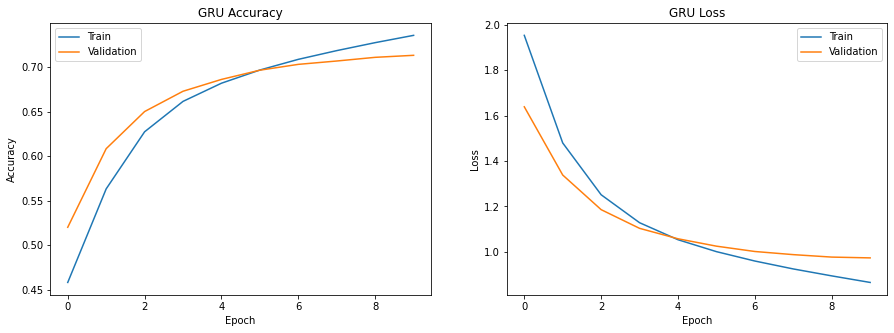

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

plt.sca(axs[0])
plt.plot(GRU_history.history['accuracy'])
plt.plot(GRU_history.history['val_accuracy'])
plt.title('GRU Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.sca(axs[1])
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [10]:
_, enc_h = GRU_model.get_layer('EncoderGRU').output
GRU_encoder_model = Model(GRU_model.get_layer('EncoderInput').input , enc_h)

dec_initial_h = Input((states_num,))
dec_output, dec_h = GRU_model.get_layer('DecoderGRU')(GRU_model.get_layer('DecoderEmbedding').output,
                                                      initial_state= dec_initial_h)
dec_output = GRU_model.get_layer('OutputDropout')(dec_output)
dec_output = GRU_model.get_layer('Classifier')(dec_output)
GRU_decoder_model = Model([GRU_model.get_layer('DecoderInput').input, dec_initial_h],
                      [dec_output, dec_h])

In [41]:
verse_index = np.random.randint(len(df.verse))
input_verse = np.expand_dims(encoder_input_data[verse_index], 0)
next_char = "SOL"
predicted_verse = ""
state_h = GRU_encoder_model.predict(input_verse)

while True:

    input_char = np.array(char2index[next_char]).reshape((1,1))
    probs, state_h = GRU_decoder_model.predict([input_char, state_h])
    next_char = index2char[np.random.choice(range(dict_size), p=probs.flatten())]

    if next_char == "EOL":
      break

    predicted_verse += next_char

print()
print('GRU:')
print("بیت ورودی:")
print(df.verse[verse_index])
print()
print("بیت خروجی:")
print(predicted_verse)

1/1 [==============================] - 0s 26ms/step

GRU:
بیت ورودی:
چو جنگ آیدش پیش جنگ آورد / سر شهریاران به چنگ آورد

بیت خروجی:
بفرمود کس را سراید زمان / نخستین گرد تیز کشته نهان
